In [4]:
# 필요 라이브러리 & 패키지 임포트
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)
import warnings
warnings.filterwarnings('ignore')

'''
활용한 데이터: 외부에서 취합하여 만든 유니콘 기업 데이터 & 제공받은 데이터(분석에 용이하게 가공한 데이터 load)
구하고자 하는 것: 1인당 연금보험료의 연평균 성장률
'''

# 외부에서 취합한 유니콘 데이터 및 제공받은 데이터(가공) Load
df = pd.read_csv('./company_nps_data.csv', encoding='cp949')
uni = pd.read_csv('./제공데이터_연금보험료.csv', index_col=0)

# 제공받은 데이터(가공) 1인당 연금보험료 feature 생성
df['월연금보험료/월직원수'] = df['월별_연금보험료']/df['월별_직원수']

# 외부에서 취합한 유니콘 데이터 1인당 연금보험료 연평균 성장률 계산을 위한 피봇테이블 생성
uni2 = uni.pivot_table(index='회사ID', columns='년도', values='월연금보험료/월직원수')

# 제공받은 데이터(가공) 1개년도 데이터만 존재하는 경우 소거(연평균 성장률 계산을 위해선 최소 2개년도 이상 데이터 필요)
# (10109, 3)에서 소거 후 (7700, 3). 중복 제외한 기업 수(unique value): 2589개
df2 = df.pivot_table(index=['회사ID', '년도'], values='월연금보험료/월직원수')
df2 = df2.reset_index()
duplicate_data = df2.duplicated('회사ID', keep=False).loc[df2.duplicated('회사ID', keep=False)].index.tolist()
df3 = df2.loc[df2.index.isin(duplicate_data)]

# 제공받은 데이터(가공)의 1인당 연금보험료 연평균 성장률 계산을 위한 피봇테이블 생성
df4 = df3.pivot_table(index='회사ID', columns='년도', values='월연금보험료/월직원수')

''' 
연평균 성장률(CARG) 공식: CAGR = ((종료값/초기값)^(1/기간수)) - 1 
'''
# 기간수 컬럼 생성
df4['기간수'] = 0
for i in range(len(df4)):
    df4.iloc[i, 5] = df4.iloc[i].notnull().sum() - 2

# 결측치가 있는 연도: 앞뒤 값으로 결측치 채우기
# 연평균 성장률 공식에서 중요한 것은 초기값(시작값)과 종료값이므로, 앞뒤의 값으로 결측치를 채워도 문제되지 않음
df5 = df4[[2015, 2016, 2017, 2018, 2019]].copy()
df5.T.fillna(method='ffill', inplace=True)
df5.T.fillna(method='bfill', inplace=True)
df5['기간수'] = df4['기간수']

# 외부에서 취합한 유니콘 데이터 1인당 연금보험료 연평균 성장률(CARG) 계산
# 외부에서 취합한 유니콘 데이터는 2015년~2019년까지 결측치가 없으므로 <기간수 컬럼 value = 4>로 설정
uni2['기간수'] = 4
uni2['연평균 성장률(%)'] = ((uni2[2019]/uni2[2015]) ** (1/uni2['기간수']) - 1) * 100

# 기존 유니콘 기업의 1인당 연금보험료 연평균 성장률 최솟값 확인 : 1.25%
display(uni2.describe())

# 제공받은 데이터(가공)의 1인당 연금보험료 연평균 성장률 소거 기준 : 1.25% 미만
# 제공받은 데이터(가공)의 1인당 연금보험료 연평균 성장률 계산
df5['연평균 성장률(%)'] = ((df5[2019]/df5[2015]) ** (1/df5['기간수']) - 1) * 100
df6 = df5.loc[df5['연평균 성장률(%)'] >= 1.25]
data = df6.sort_values(by='연평균 성장률(%)', ascending=False)

# 1인당 연금보험료 연평균 성장률 상위 50개 기업 추출
data_top50 = data['연평균 성장률(%)'].head(50).to_frame().reset_index()

년도,2015,2016,2017,2018,2019,기간수,연평균 성장률(%)
count,11.00,11.00,11.00,11.00,11.00,11.00,11.00
mean,332675.42,346986.41,381093.13,410404.51,442571.70,4.00,5.08
std,473545.52,506524.61,576211.00,620364.39,670807.43,0.00,3.09
min,93344.45,97955.25,91384.62,106823.75,117878.67,4.00,1.25
25%,109466.22,109321.43,112034.78,120805.11,130935.45,4.00,2.80
50%,129905.23,128797.15,132366.36,137369.59,147293.71,4.00,4.45
75%,145350.92,141787.40,145965.78,155148.57,164302.07,4.00,6.80
max,1342831.73,1409297.51,1586949.71,1730305.28,1858434.23,4.00,10.77


# 그래프 2개

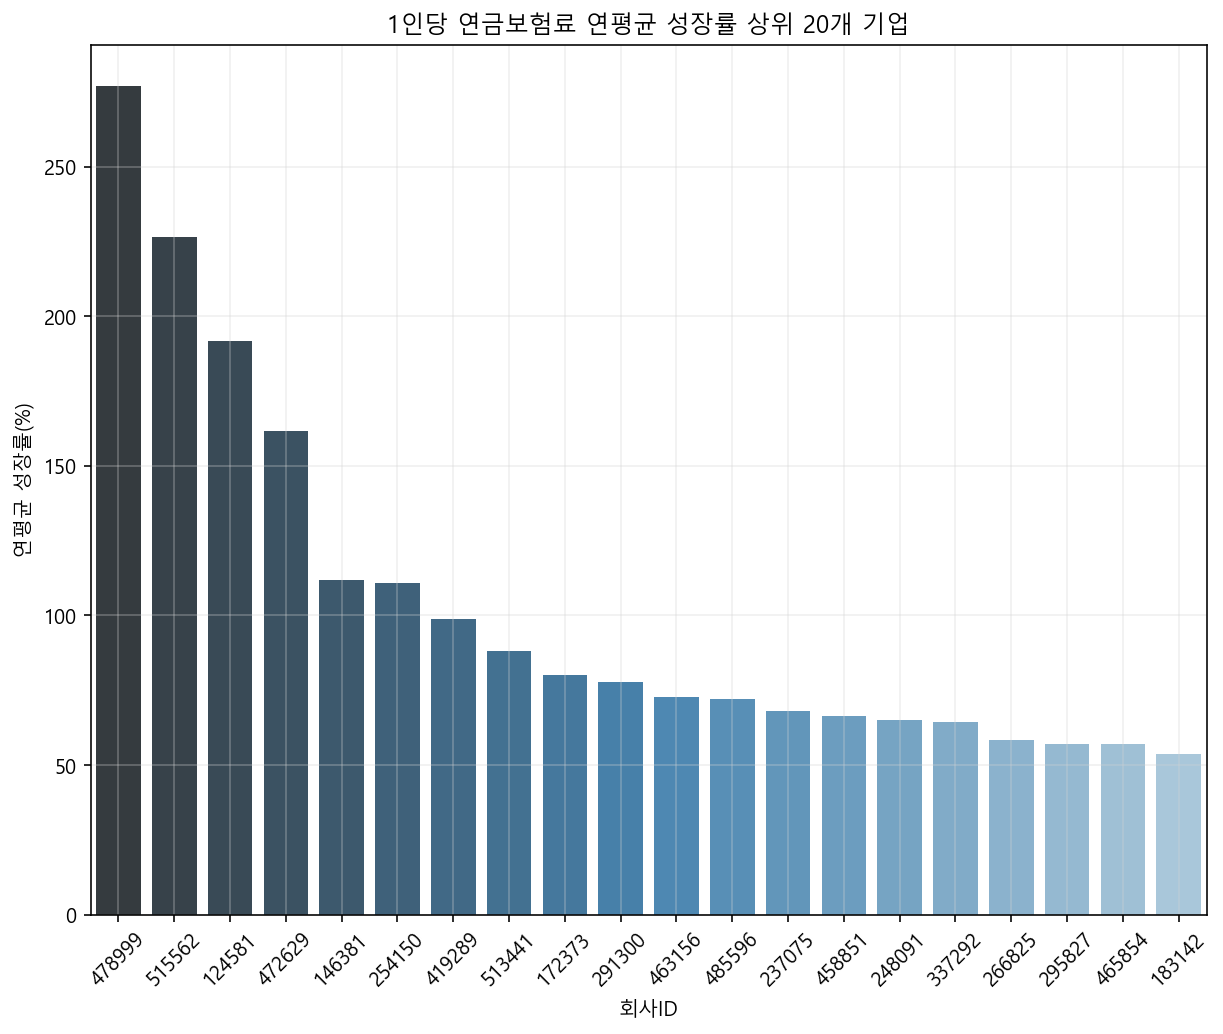

In [28]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

plt.figure(figsize=(10, 8))
plt.xticks(rotation = 45 )
data_top20 = data_top50.sort_values(by='연평균 성장률(%)', ascending=False).head(20)
sns.barplot(data=data_top20, x='회사ID', y='연평균 성장률(%)', palette="Blues_d", order=data_top10['회사ID'])
plt.title('1인당 연금보험료 연평균 성장률 상위 20개 기업')
plt.grid(color='lightgrey', alpha=0.35)

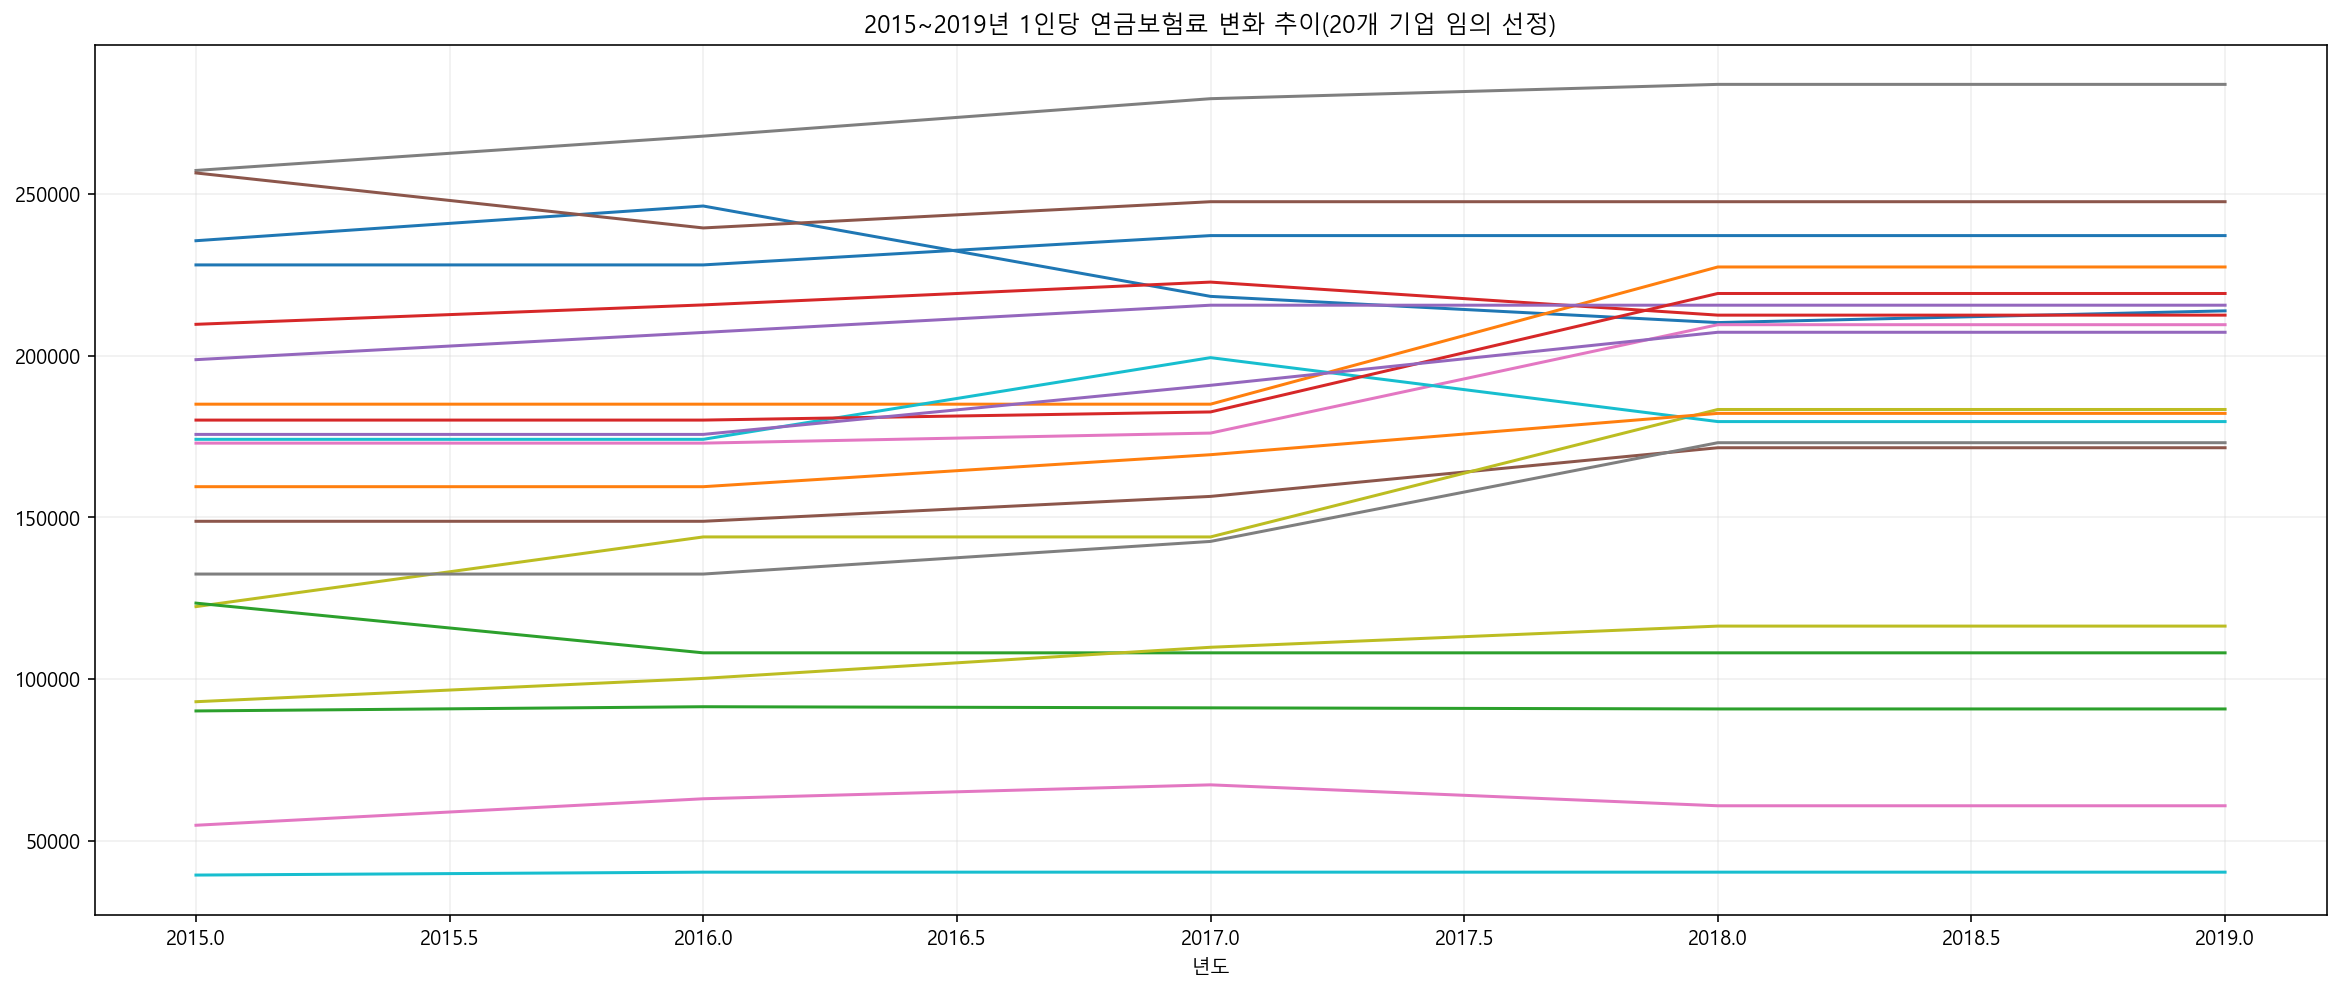

In [69]:
df5[[2015, 2016, 2017, 2018, 2019]].T.iloc[:, :20].plot(figsize=(20, 8), legend=False)
plt.title('2015~2019년 1인당 연금보험료 변화 추이(20개 기업 임의 선정)')
plt.grid(color='lightgrey', alpha=0.34)